In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## LOAD DATASETS

In [3]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3,contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(dataset_path,transform=image_transforms)
len(dataset)

2300

In [5]:
2300*0.75

1725.0

In [6]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [7]:
num_classes = len(dataset.classes)
num_classes

6

In [8]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size,val_size

(1725, 575)

In [9]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size,val_size])


In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [11]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [12]:
labels[1]

tensor(3)

In [13]:
images[1].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.5528543].


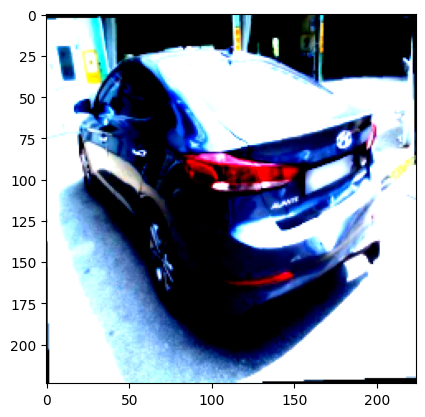

In [14]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

## MODEL 1 : CNN

In [15]:
import torch
import torch.nn as nn

class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),  # 16, 224, 224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 16, 112, 112

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # 32, 112, 112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 32, 56, 56

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # 64, 56, 56
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 64, 28, 28

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1), # 64, 28, 28
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.network(x)


In [16]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
len(train_loader.dataset)

1725

In [18]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start/int(60)} seconds")     
    
    return all_labels, all_predictions

In [19]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 1.74
Batch: 20, Epoch: 1, Loss: 1.78
Batch: 30, Epoch: 1, Loss: 1.74
Batch: 40, Epoch: 1, Loss: 1.75
Batch: 50, Epoch: 1, Loss: 1.63
Epoch [1/5], Avg Loss: 1.8009
*** Validation Accuracy: 39.65% ***
Batch: 10, Epoch: 2, Loss: 1.49
Batch: 20, Epoch: 2, Loss: 1.35
Batch: 30, Epoch: 2, Loss: 1.42
Batch: 40, Epoch: 2, Loss: 1.15
Batch: 50, Epoch: 2, Loss: 1.51
Epoch [2/5], Avg Loss: 1.4207
*** Validation Accuracy: 45.22% ***
Batch: 10, Epoch: 3, Loss: 1.08
Batch: 20, Epoch: 3, Loss: 0.85
Batch: 30, Epoch: 3, Loss: 1.38
Batch: 40, Epoch: 3, Loss: 1.62
Batch: 50, Epoch: 3, Loss: 1.15
Epoch [3/5], Avg Loss: 1.2470
*** Validation Accuracy: 48.35% ***
Batch: 10, Epoch: 4, Loss: 1.06
Batch: 20, Epoch: 4, Loss: 1.49
Batch: 30, Epoch: 4, Loss: 1.19
Batch: 40, Epoch: 4, Loss: 1.11
Batch: 50, Epoch: 4, Loss: 1.30
Epoch [4/5], Avg Loss: 1.1240
*** Validation Accuracy: 53.57% ***
Batch: 10, Epoch: 5, Loss: 0.88
Batch: 20, Epoch: 5, Loss: 0.89
Batch: 30, Epoch: 5, Loss: 1.03


## MODEL 2: CNN with Regularization

In [20]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [21]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=5)

Batch: 10, Epoch: 1, Loss: 18.72
Batch: 20, Epoch: 1, Loss: 7.16
Batch: 30, Epoch: 1, Loss: 2.16
Batch: 40, Epoch: 1, Loss: 1.63
Batch: 50, Epoch: 1, Loss: 1.42
Epoch [1/5], Avg Loss: 9.4830
*** Validation Accuracy: 44.70% ***
Batch: 10, Epoch: 2, Loss: 1.43
Batch: 20, Epoch: 2, Loss: 1.11
Batch: 30, Epoch: 2, Loss: 1.42
Batch: 40, Epoch: 2, Loss: 1.31
Batch: 50, Epoch: 2, Loss: 1.41
Epoch [2/5], Avg Loss: 1.3618
*** Validation Accuracy: 44.70% ***
Batch: 10, Epoch: 3, Loss: 1.30
Batch: 20, Epoch: 3, Loss: 1.31
Batch: 30, Epoch: 3, Loss: 1.25
Batch: 40, Epoch: 3, Loss: 1.26
Batch: 50, Epoch: 3, Loss: 1.18
Epoch [3/5], Avg Loss: 1.2990
*** Validation Accuracy: 49.04% ***
Batch: 10, Epoch: 4, Loss: 1.11
Batch: 20, Epoch: 4, Loss: 1.58
Batch: 30, Epoch: 4, Loss: 1.02
Batch: 40, Epoch: 4, Loss: 1.20
Batch: 50, Epoch: 4, Loss: 1.09
Epoch [4/5], Avg Loss: 1.2071
*** Validation Accuracy: 49.91% ***
Batch: 10, Epoch: 5, Loss: 1.18
Batch: 20, Epoch: 5, Loss: 1.13
Batch: 30, Epoch: 5, Loss: 1.10

In [30]:
num_classes

6

## MODEL 3: Transfer Learning with Efficient

In [22]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

In [23]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x              

In [24]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 1.73
Batch: 20, Epoch: 1, Loss: 1.38
Batch: 30, Epoch: 1, Loss: 1.46
Batch: 40, Epoch: 1, Loss: 1.41
Batch: 50, Epoch: 1, Loss: 1.14
Epoch [1/5], Avg Loss: 1.4947
*** Validation Accuracy: 57.74% ***
Batch: 10, Epoch: 2, Loss: 1.21
Batch: 20, Epoch: 2, Loss: 0.95
Batch: 30, Epoch: 2, Loss: 1.11
Batch: 40, Epoch: 2, Loss: 1.21
Batch: 50, Epoch: 2, Loss: 1.12
Epoch [2/5], Avg Loss: 1.1222
*** Validation Accuracy: 62.26% ***
Batch: 10, Epoch: 3, Loss: 0.99
Batch: 20, Epoch: 3, Loss: 0.99
Batch: 30, Epoch: 3, Loss: 1.11
Batch: 40, Epoch: 3, Loss: 1.07
Batch: 50, Epoch: 3, Loss: 0.92
Epoch [3/5], Avg Loss: 1.0068
*** Validation Accuracy: 62.26% ***
Batch: 10, Epoch: 4, Loss: 1.06
Batch: 20, Epoch: 4, Loss: 1.19
Batch: 30, Epoch: 4, Loss: 0.93
Batch: 40, Epoch: 4, Loss: 0.89
Batch: 50, Epoch: 4, Loss: 0.86
Epoch [4/5], Avg Loss: 0.9533
*** Validation Accuracy: 63.65% ***
Batch: 10, Epoch: 5, Loss: 0.75
Batch: 20, Epoch: 5, Loss: 1.10
Batch: 30, Epoch: 5, Loss: 0.93


### Model 4: Transfer Learning with ResNet

In [25]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.2):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [26]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 0.94
Batch: 20, Epoch: 1, Loss: 0.70
Batch: 30, Epoch: 1, Loss: 0.63
Batch: 40, Epoch: 1, Loss: 0.56
Batch: 50, Epoch: 1, Loss: 0.64
Epoch [1/5], Avg Loss: 0.8807
*** Validation Accuracy: 72.70% ***
Batch: 10, Epoch: 2, Loss: 0.48
Batch: 20, Epoch: 2, Loss: 0.43
Batch: 30, Epoch: 2, Loss: 0.41
Batch: 40, Epoch: 2, Loss: 0.61
Batch: 50, Epoch: 2, Loss: 0.42
Epoch [2/5], Avg Loss: 0.4515
*** Validation Accuracy: 75.30% ***
Batch: 10, Epoch: 3, Loss: 0.33
Batch: 20, Epoch: 3, Loss: 0.21
Batch: 30, Epoch: 3, Loss: 0.50
Batch: 40, Epoch: 3, Loss: 0.23
Batch: 50, Epoch: 3, Loss: 0.23
Epoch [3/5], Avg Loss: 0.3705
*** Validation Accuracy: 77.57% ***
Batch: 10, Epoch: 4, Loss: 0.35
Batch: 20, Epoch: 4, Loss: 0.22
Batch: 30, Epoch: 4, Loss: 0.34
Batch: 40, Epoch: 4, Loss: 0.18
Batch: 50, Epoch: 4, Loss: 0.29
Epoch [4/5], Avg Loss: 0.2432
*** Validation Accuracy: 77.39% ***
Batch: 10, Epoch: 5, Loss: 0.12
Batch: 20, Epoch: 5, Loss: 0.20
Batch: 30, Epoch: 5, Loss: 0.24


### Model Evaluation using Confusion Matrix and Classification Report

In [27]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.74      0.80       124
           1       0.65      0.80      0.72        93
           2       0.88      0.86      0.87       136
           3       0.80      0.71      0.75        73
           4       0.67      0.81      0.73        67
           5       0.82      0.76      0.78        82

    accuracy                           0.78       575
   macro avg       0.78      0.78      0.78       575
weighted avg       0.79      0.78      0.79       575



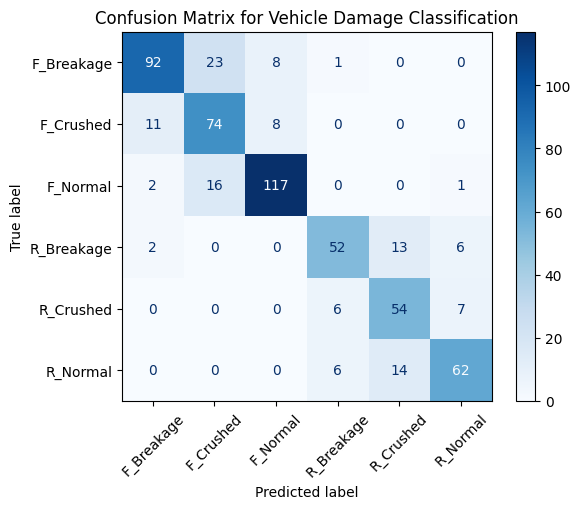

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

### Save the Model

In [29]:
torch.save(model.state_dict(), 'saved_model.pth')